In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imageio.v2 import imread
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.ndimage
import tomosipo
import os
import tifffile
import astra

import autodiffCT.pipeline as cxpl
import autodiffCT.optimizer as ctxopt
import autodiffCT.tomography.reconstruction as recon

from autodiffCT.tomography.spectral import effective_spectrum, spectral_projection
from autodiffCT.image.segmentation import ThresholdOperator, SegmentationMaskOperator, apply_thresholds
from autodiffCT.tomography.project import AutogradedTomosipoOperator

from autodiffCT.ISP import ISP, global_gradient_method


def plot_imgs(height=6, cmap="gray", clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    fig.patch.set_alpha(1.0)
    if len(kwargs) == 1:
        axes = [axes]
    it = 0
    for ax, (k, v) in zip(axes, kwargs.items()):
        if isinstance(v, torch.Tensor):
            v = v.cpu().numpy()
        if isinstance(clim, list):
            pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim[it])
        else:
            pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
        it += 1
    fig.tight_layout()
    plt.show()

/export/scratch2/schoonho/anaconda3/envs/pipeline_python310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/export/scratch2/schoonho/anaconda3/envs/pipeline_python310/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /export/scratch2/schoonho/anaconda3/envs/pipeline_python310/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def load_PlayDoh(proj_path, object_nr=1, scan_nr=20, Angles=600, zoom=False):          
    print("Object", object_nr)
    FOLDER = proj_path + f'scan{object_nr}/'

    #Load all data filenames                                                          
    filenames = sorted(os.listdir(FOLDER))                                            

    #Select only filenames corresponding to the data                                  
    substring = '.tif'                                                                
    files = [s for s in filenames if substring in s]                                                                                                     

    #Find resolution                                                                  
    resolution = tifffile.imread(FOLDER + files[0]).shape                                                                                             

    #Darkfield data files                                                             
    darkfiles = [s for s in filenames if 'di' in s]                                   
    #Flatfield dat files                                                              
    flatfiles = [s for s in filenames if 'io0' in s]                                  
    #Main data files                                                                  
    datafiles = [s for s in filenames if 'scan_0' in s]                                                                               

    #Define array with zeros of (numberoffiles,res1,res2) and load the data and flatfields
    Data = np.zeros((len(datafiles), resolution[0], resolution[1]))                   

    print("Loading data...")                                                          
    DarkData = np.zeros((resolution[0], resolution[1]))       
    for f in darkfiles:                                                                                                                               
        DarkData += tifffile.imread(FOLDER + f)                                       
    DarkData = DarkData/len(darkfiles)                                                

    FlatData = np.zeros((resolution[0], resolution[1]))                               
    for f in flatfiles:                                                                                                                                   
        FlatData += tifffile.imread(FOLDER + f)                                       
    FlatData = FlatData/len(flatfiles)                                                

    fileCounter = 0                                                                   
    for f in datafiles:                                                                                                                                
        Data[fileCounter, :, :] = tifffile.imread(FOLDER + f)                         
        fileCounter += 1                                                              

    if(fileCounter != 1800):                                                          
        print(fileCounter)                                                            
        print("No 1800 projections found!")                                            

    print("Correcting")                                                                                                                                                                                             
    if 1800 % Angles != 0:                                                            
        raise Exception("Has to be divisor of 1800")                                  
    steps = int(1800/Angles)  

    NewData = np.zeros((Angles, resolution[0], resolution[1]))                        
    index = 0                                                                         
    for i in range(0,Data.shape[0], steps):                                                                                                            
        NewData[index,:,:] = np.log((FlatData - DarkData)/(Data[i,:,:] - DarkData))   
        index +=1                                                                     
    del Data                                                                          

    CorData = np.swapaxes(NewData,0,1)                                                

    #Taken from settings file                                                         
    DETSIZE = 0.149600                                                                
    SOD = 441.396942                                                                  
    SDD = 698.000977                                                                  
    MAGN = SDD/SOD                                                                    
    CONV = MAGN/DETSIZE  
    
    # NOTE: To crop we can use this and decrease memory
    #Use this to crop if needed for memory: CorData = zoom(CorData, (0.5, 1, 0.5))
    if zoom:
        CorData = scipy.ndimage.zoom(CorData, (0.5, 1, 0.5)) #middle is angles           
                                                     
        vol_geom = astra.create_vol_geom(478,478,478)                                     
        angles = np.linspace(0,360*np.pi/180, Angles, False)

        proj_geom = astra.create_proj_geom('cone',
                                           DETSIZE*CONV,
                                           DETSIZE*CONV,
                                           380,
                                           478,
                                           angles,
                                           SOD*CONV,
                                           (SDD-SOD)*CONV)
    else:                                                          
        vol_geom = astra.create_vol_geom(956,956,956)                                     
        angles = np.linspace(0,360*np.pi/180, Angles, False)

        proj_geom = astra.create_proj_geom('cone',
                                           DETSIZE*CONV,
                                           DETSIZE*CONV,
                                           760,
                                           956,
                                           angles,
                                           SOD*CONV,
                                           (SDD-SOD)*CONV)

    # Define tomosipo objects                                                         
    ts_pg = tomosipo.astra.from_astra(proj_geom)                                            
    ts_vg = tomosipo.astra.from_astra(vol_geom)                                             

    A = tomosipo.operator(ts_vg, ts_pg)
    return A, torch.tensor(CorData, dtype=torch.float32)

# Load Play-Doh dataset

The Play-Doh dataset can be downloaded from https://zenodo.org/record/5866228. Different play-doh objects can be used (numbered 1 to 6), but object number 2, scan number 20 is used for the images in the paper

In [4]:
# Zoom cuts away background, making the volume 8x smaller (or 4x for central slice)
ZOOM = True

# Path to playdoh dataset projections. Should end on SOMETHING/projections/
proj_path = '/YOUR PATH TO PLAYDOH DATASET HERE/projections/'

# Object nr. between 1 and 6
A, y = load_PlayDoh(proj_path, object_nr=2, scan_nr=20, Angles=1800, zoom=ZOOM)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

Object 2
Loading data...
Correcting


In [5]:
# Get date to date the saves:
from datetime import datetime
import os

date_str = datetime.today().strftime('0%Y-%m-%d')
path = 'experimental_results/'+date_str +'/'

# Make directory if it does not exist
folder = os.path.dirname(path)
if not os.path.exists(folder):
    os.makedirs(folder)

In [6]:
# It is recommended to only estimate the BH correction on the central slice to reduce computation time
use_central_slice = True

if use_central_slice:
    centr_slice = y.shape[0]//2
    A_pg = A.projection_geometry
    A_vg = A.volume_geometry
    vox_size = A_vg.size[0]/A_vg.shape[0]

    # A factor lower than 1 zooms in, cutting away some background
    factor = 0.7
    central_vg = tomosipo.volume(shape=(1, A_vg.shape[1], A_vg.shape[2]), size=(factor*vox_size, factor*A_vg.size[1], factor*A_vg.size[2]))
    central_pg = tomosipo.cone(shape=(1, A_pg._shape[1]),
                               size=(vox_size, A_pg.det_size[1]),
                               angles=A_pg.num_angles,
                               src_det_dist=np.linalg.norm(A_pg.src_pos-A_pg.det_pos),
                               src_orig_dist=np.linalg.norm(A_pg.src_pos))

    # Create tomosipo geometries
    centr_A = tomosipo.operator(central_vg, central_pg)

    centr_y = y[centr_slice,...].unsqueeze(0)

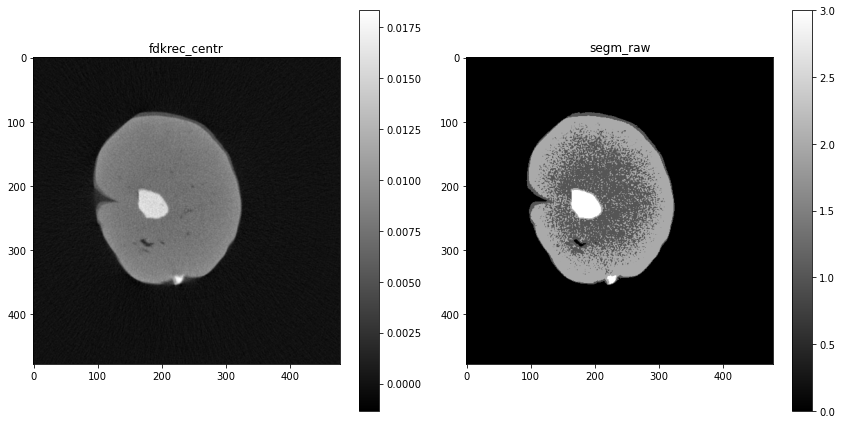

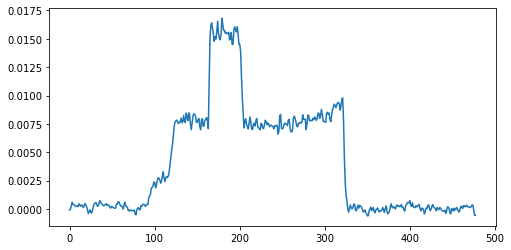

In [7]:
if ZOOM:
    slice_idx = 440//2
else:
    # These slices are such that there is actual beam hardening present with also a stone inside the play-doh.
    slice_idx = 440# Obj1:300, Obj2: 440, Obj3: 480, Obj4: 500, Obj5: 710, Obj6: 360

if use_central_slice:
    with torch.no_grad():
        fdkrec_centr = recon.fdk(centr_A, centr_y.cpu(), padded=True)
        objreg_op = SegmentationMaskOperator(bins=64, device='cpu', n_classes=2,
                                        gamma=100.0, re_init_at_call=True)
        segm_op = ThresholdOperator(n_classes=4, bins=64, device='cpu', gamma=100.0,
                                    re_init_at_call=True, split_classes=False)
        segm_raw = segm_op(objreg_op(fdkrec_centr))

        torch.save(fdkrec_centr.cpu().detach(), path + 'PlayDoh_fdk_raw.torch')
        torch.save(segm_raw.cpu().detach(), path + 'PlayDoh_segm_raw.torch')


    plot_imgs(fdkrec_centr=fdkrec_centr[0], segm_raw=segm_raw[0].cpu().detach())
    torch.cuda.empty_cache()

    # Plot intensity through central line
    _, axes = plt.subplots(1, 1, figsize=(8, 4))
    axes.plot(fdkrec_centr[0, slice_idx,:].detach().cpu().numpy())
    plt.show()

# Correct with ISP method

In [8]:
# attenuations must be Nr_materials x nr_bins
N = 3
E_m = 3 # Number of bins
max_volt = 100.0
energies = torch.linspace(5, max_volt, E_m, device=device)
spectrum = torch.ones(size=(E_m,), device=device) / E_m

# Make autogradable projector
if use_central_slice:
    A_diff = AutogradedTomosipoOperator(centr_A)
else:
    A_diff = AutogradedTomosipoOperator(A)

In [ ]:
losses = []
steps = 20

# with torch.autograd.graph.save_on_cpu(pin_memory=True): #<-- for full recon size to store tensors on RAM
if use_central_slice:
    corrected_y, spectrum_c, attenuations_c, thresholds_c = ISP(centr_y.clone().to(device),
                                                A_diff,
                                                N,
                                                energies,
                                                spectrum.clone(),
                                                steps=steps,
                                                cone=True,
                                                losses=losses,
                                                thr_bins=56,
                                                lmin_steps=300,
                                                lrs=[5*1e-5, 1e-3])
else:
    corrected_y, spectrum_c, attenuations_c, thresholds_c = ISP(y.clone().to(device),
                                                A_diff,
                                                N,
                                                energies,
                                                spectrum.clone(),
                                                steps=steps,
                                                cone=True,
                                                losses=losses,
                                                thr_bins=64,
                                                lmin_steps=100,
                                                lrs=[5*1e-5, 1e-3])

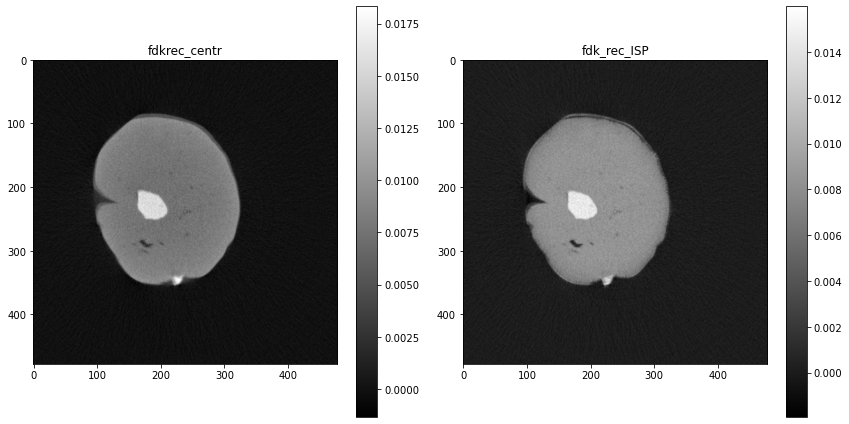

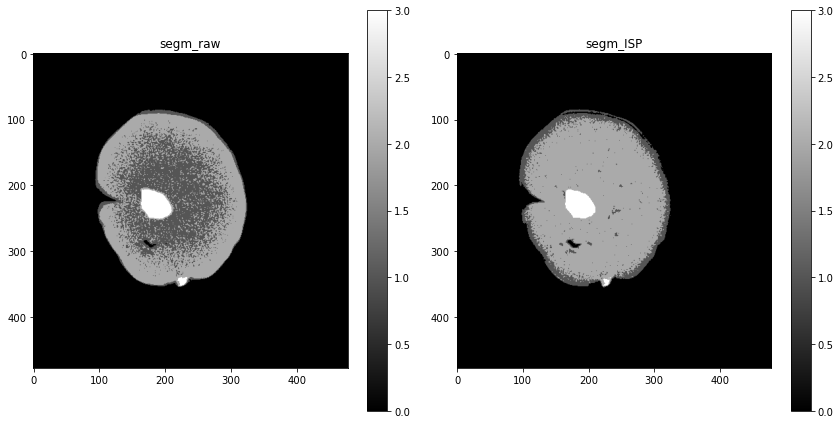

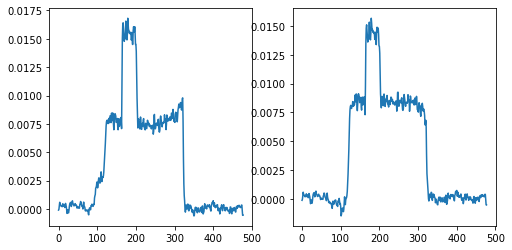

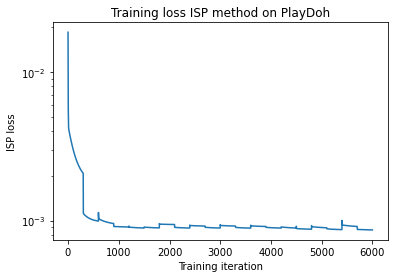

In [11]:
if use_central_slice:
    with torch.no_grad():
        fdkrec_ISP = recon.fdk(centr_A, corrected_y.cpu(), padded=True).squeeze()
        
        segm_op = ThresholdOperator(n_classes=4, bins=64, device='cpu', gamma=1000.0,
                            re_init_at_call=True, split_classes=False)
        _ = segm_op(objreg_op(fdkrec_ISP))
        thrs = segm_op.parameters['thresholds'].value.clone().cpu().detach()
        segm_corrected_ISP = apply_thresholds(fdkrec_ISP.cpu(), thrs)

    ## Plot slice
    plot_imgs(fdkrec_centr=fdkrec_centr[0], fdk_rec_ISP=fdkrec_ISP)
    plot_imgs(segm_raw=segm_op(objreg_op(fdkrec_centr))[0].cpu().detach(), segm_ISP=segm_corrected_ISP.cpu().detach())

    # Plot intensity through central line
    _, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].plot(fdkrec_centr[0,slice_idx,:].detach().cpu().numpy())
    axes[1].plot(fdkrec_ISP[slice_idx,:].detach().cpu().numpy())
    plt.show()

torch.save(fdkrec_ISP, path + 'rec_corrected_ISP_PlayDoh.torch')
torch.save(corrected_y, path + 'corrected_y_ISP_PlayDoh.torch')
torch.save(segm_corrected_ISP, path + 'segm_corrected_ISP_PlayDoh.torch')

plt.semilogy(losses)
plt.title("Training loss ISP method on PlayDoh")
plt.xlabel("Training iteration")
plt.ylabel("ISP loss")
plt.savefig(path + "ISP_training_loss_PlayDoh.pdf")
plt.show()
torch.save(torch.tensor(losses), path + "ISP_PlayDoh_losses.torch")

# Global Gradient method

In [12]:
# attenuations must be Nr_materials x nr_bins
N = 3
E_m = 3 # Number of bins
max_volt = 100.0
energies = torch.linspace(5, max_volt, E_m, device=device)
spectrum = torch.ones(size=(E_m,), device=device) / E_m

In [13]:
steps = 150
losses_glob = []
if use_central_slice:
    corr_y_glob, spectrum_glob, atten_glob, thresholds_glob = global_gradient_method(centr_y.clone().to(device),
                                                                            A_diff,
                                                                            N,
                                                                            energies,
                                                                            spectrum.clone(),
                                                                            steps=steps,
                                                                            cone=True,
                                                                            losses=losses_glob,
                                                                            local_min_steps=30,
                                                                            lrs=[1e-4,2*1e-5,1e-3])

  0%|                                                                                                                                 | 0/150 [00:00<?, ?it/s]/export/scratch2/schoonho/anaconda3/envs/pipeline_python310/lib/python3.10/site-packages/tomosipo/links/torch.py:55: UserWarning: The parameter initial_value is of type torch.int32; expected `torch.float32`. The type has been automatically converted. Use `ts.link(x.to(dtype=torch.float32))' to inhibit this warning. 
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [04:35<00:00,  1.83s/it]


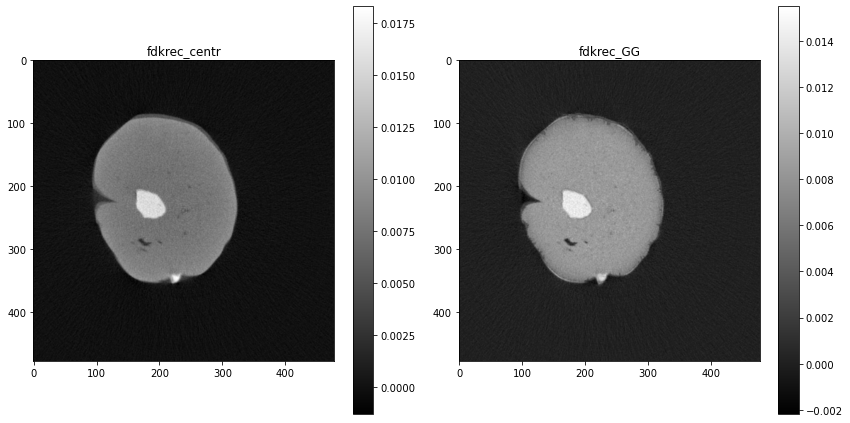

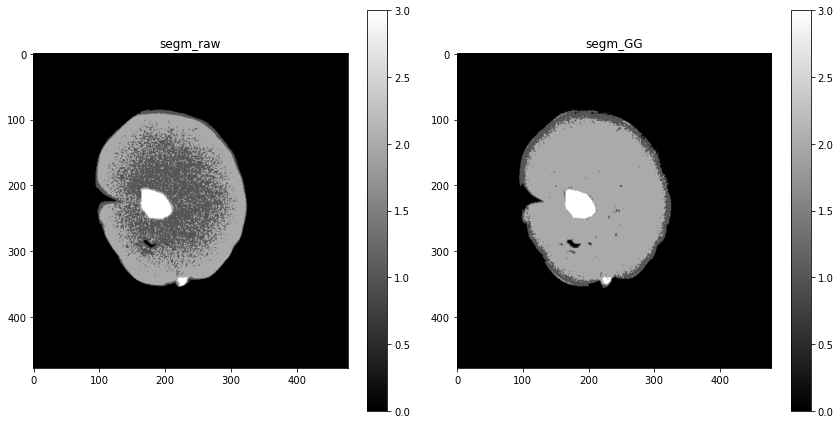

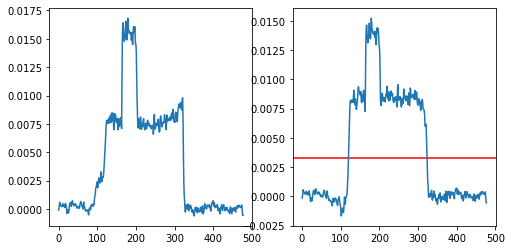

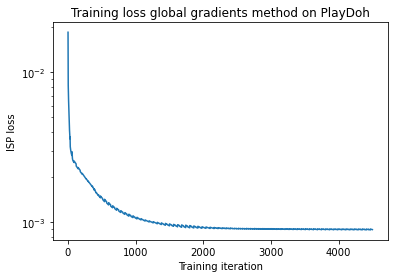

In [14]:
if use_central_slice:
    with torch.no_grad():
        fdkrec_GG = recon.fdk(centr_A, corr_y_glob.cpu(), padded=True).squeeze()
        segm_op = ThresholdOperator(n_classes=4, bins=64, device='cpu', gamma=1000.0,
                            re_init_at_call=True, split_classes=False)
        _ = segm_op(objreg_op(fdkrec_GG))
        thrs = segm_op.parameters['thresholds'].value.clone().cpu().detach()
        segm_corrected_GG = apply_thresholds(fdkrec_GG.cpu(), thrs)

    ## Plot slice
    plot_imgs(fdkrec_centr=fdkrec_centr[0], fdkrec_GG=fdkrec_GG)
    plot_imgs(segm_raw=segm_raw[0].cpu().detach(), segm_GG=segm_corrected_GG.cpu().detach())

    # Plot intensity through central line
    _, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].plot(fdkrec_centr[0,slice_idx,:].detach().cpu().numpy())
    axes[1].axhline(y=thrs[0], color='r', linestyle='-')
    axes[1].plot(fdkrec_GG[slice_idx,:].detach().cpu().numpy())
    plt.show()

torch.save(fdkrec_GG, path + 'rec_corrected_GlobalGradients_PlayDoh.torch')
torch.save(corr_y_glob, path + 'corrected_y_GlobalGradients_PlayDoh.torch')
torch.save(segm_corrected_GG, path + 'segm_corrected_GlobalGradients_PlayDoh.torch')

plt.semilogy(losses_glob)
plt.title("Training loss global gradients method on PlayDoh")
plt.xlabel("Training iteration")
plt.ylabel("ISP loss")
plt.savefig(path + 'BH_GlobalGradients_training_loss_PlayDoh.pdf')
plt.show()
torch.save(torch.tensor(losses_glob), path + "PlayDoh_GlobalGradients_losses.torch")